# Imports

Install the packages that are necessary for this example. As you get more familiar with coding in Python you will add/remove some of these packages and install your preferred ones. For now, you can simple execute this cell to install what is needed.

In [ ]:
# Mount YOUR google drive. You'll need to "Add shortcut to Drive" for our shared folder for it to show up here.
# Use the URL shown below in the output to authorize this Colab session to access you GDrive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

! pip install geopandas
! pip install geopy
! pip install -U plotly

import pandas as pd
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopy.distance
from shapely.geometry import Point, Polygon
import csv
import math
import numpy as np
import scipy 
from scipy import stats as sts
import plotly.express as px
from numpy.random import default_rng
from plotnine import *
import time
import matplotlib.pyplot as plt

rng = default_rng(13)

Mounted at /content/drive/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 54.8 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


# <font color='orange'> Data </font>

This example will use some data. You must tell the notebook where to look for these data. Here, I am telling that the data is in my google drive (/content/drive/MyDrive/) in a folder called 'Courses' in a subfolder called 'SYDE_599'. You can download the data for this example from LEARN and save at your preferred location in your computer, you just need to point the notebook to where the data are.

In [ ]:
# Modify this according to the path in your computer
main_dir = '/content/drive/MyDrive/Courses/SYDE_599/'

Read the data for this example and plot the first 3 rows.

In [ ]:
# pd.read_csv(path to file) reads the file in the provided path
df_Alameda = pd.read_csv(main_dir + 'Alameda.csv')

# Print the first (n) terms of the dataframe
df_Alameda.head(3)

,Latitude,Longitude,UseCategory,Buildings,Units,Stories,Rooms,Beds,YearBuilt,Baths,Area,LandValue,ImprovementValue,HomeValue,LatestDocument
0,37.756951,-122.237670,Single-family Detached,1,1,1,6,3,1900,1.0,1134,54029,12106,66135,1969
1,37.734668,-122.239088,Single-family Detached,1,1,1,6,4,1957,2.0,1196,34300,40577,74877,1969
2,37.734820,-122.233459,Single-family Detached,1,1,1,4,2,1952,1.0,1223,40353,40802,81155,1969


In [ ]:
# And plot a map with the data underneath
df_Alameda['YearBuilt'] = df_Alameda['YearBuilt'].apply(lambda x: 1900 if x < 1900 else x)
df_plt = df_Alameda.copy()
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'YearBuilt', 
                        color_continuous_scale='Viridis',
                        zoom=12.2,
                        height=700,
                        width=800
                      )
fig.show()

# <font color='orange'> Disclaimer </font>

This example will apply some concepts of Probabilistic Seismic Hazard Analysis and Regional Risk Assessment. You are *NOT* required to learn these concepts. In fact, this HWA is meant to teach you can use concepts discussed in class to explain problems you are not familiar with. 

The goal of this HWA is to teach about modeling & simulations. In the following, I provide some context of what is being done and why. It should be sufficient for you to be able to complete this HWA. 

The concepts presented in the following are very close to what is employed in practice. However, I simplified some steps to allow you to focus on the goals of the HWA.

# <font color='orange'> Hazard (a.k.a., the earthquake) </font> 

In this HWA you are given a *simplified* worflow to simulate the impacts of earthquakes to a community. Earthquakes often occur across fault lines, which are (put simply) cracks on Earth's crust. One of the most dangerous in California fault lines is the Hayward Fault in the San Francisco Bay Area (shown below as the black strip going from SE to NW). The Hayward Fault crosses multiple populated areas and if an earthquake occurs in this fault it can cause severe losses (monetary and societal). 

Earthquakes are characterized by an *Epicentre* and a *Magnitude*. For this example, assume that the epicentre is the location where the earthquake occurs along the fault line (see here for more details [link text](https://www.usgs.gov/programs/earthquake-hazards/science-earthquakes#:~:text=The%20location%20below%20the%20earth's,the%20larger%20earthquake%20that%20follows.)).

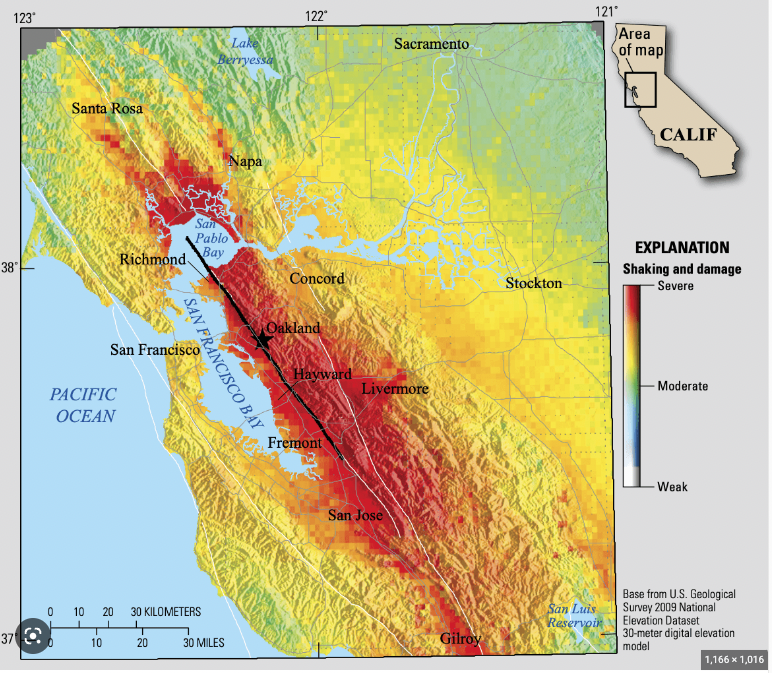

In [ ]:
# Here, we will simulate the epicentre of the earthquake as a random variable 
# uniformly distributed across the fault line. Say the fault line is 
# sufficiently-well approximated by a line (this is an approximation since 
# the earth is not flat :) ), hence it can be described by two points.
theNWPoint = (37.987, -122.390) # Northwest end of the Hayward fault (approximated)
theSWPoint = (37.603, -122.054) # Southeast end of the Hayward fault (approximated)

# Difference in latitudes
theDeltaLatitude = theNWPoint[0] - theSWPoint[0] 

# Difference in longitudes
theDeltaLongitude = theNWPoint[1] - theSWPoint[1] 

# Difference in degrees between the two points, i.e., length of the fault line
theTotalDelta = np.sqrt(theDeltaLatitude**2 + theDeltaLongitude**2) #sqrt = squared root

# Angle that the fault makes with the Equator (or any other parallel)
theAngleOfFault = np.arcsin(theDeltaLatitude / theTotalDelta)


# We want to simulate the occurrence of earthquake along the Hayward Fault.
# Let's assume that the epicentre location is equally likely to be anywhere along the fault line.
def simulateEpicentreLocation():
    # The distance between the fault end points is theTotalDelta
    #           0 ----------------- 1

    # First, simulate an epicentre location along this fault line
    theDistanceAlongTheFaultLine = rng.random() * theTotalDelta 

    # Say theDistanceAlongTheFaultLine = 0.2 of theTotalDelta, we are saying that the epicentre location is around this region
    #           0 ---E------------ 1

    # However, the fault line is 'inclined'. We need to calculate the projection of the point E on the parallels and meridians.
    # This is just trigonometry
    # Note: these calculations are more complicated in non-Euclidian spaces hence we simplify them
    theEpicentreLatitude = theSWPoint[0] + theDistanceAlongTheFaultLine * np.sin(theAngleOfFault)
    theEpicentreLongitude = theSWPoint[1] - theDistanceAlongTheFaultLine * np.cos(theAngleOfFault)
    

    # Return the latitude and longitude
    return theEpicentreLatitude,theEpicentreLongitude

In [ ]:
# Lets make sure the implementation is correct:
# Create an empty data frame with two columns and fill 100 rows with zeros
theEpicentres = pd.DataFrame()
theEpicentres['Latitude'] = [0] * 100 # equivalent to say 'add 0 one-hundred times'
theEpicentres['Longitude'] = [0] * 100


# Simulate epicentres
for i in range(100):  
  theEpicentres.loc[i,'Latitude'],theEpicentres.loc[i,'Longitude'] = simulateEpicentreLocation() # this is the function we created above


# Now let's plot in a map.
# If the implementation is correct we should see our simulated epicentre location distributed along a line similar to the figure above.
df_plt = theEpicentres
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color_continuous_scale='Viridis',
                        zoom=10,
                        height=700,
                        width=800
                      )
fig.show()

# <font color='orange'> Magnitude </font> 

The other important component of defining an earthquake is its Magnitude (or moment magnitude, to be more technical). The moment magnitude (usually represent as Mw) is a number between 0 and 10. You may have heard before that 'a magntitude 8 earthquake struck some county'. [More details for interested readers](https://www.usgs.gov/faqs/moment-magnitude-richter-scale-what-are-different-magnitude-scales-and-why-are-there-so-many).

The moment magnitude is a measure of the *energy released* by an earthquake. It is *NOT* a metric of how much the ground shakes. We will talk about that in the following. 

The moment magnitude is a logarithmic metric. Hence, an earthquake of magntiude 6.1 releases 10x more energy than an earthquake of magntiude 6.0.

For practical applications in engineering, moment magnitudes below 5.0 tend to be irrelevant (i.e., unlikely to cause damage). Earthquakes with moment magnitude < 5.0 may still be problematic for precision equipment. For example, they may cause problems for the calibration of medical devices. 

The magnitude of earthquakes is often modelled as an bounded exponential distribution. That is, the larger the magnitude the rarer it is (at an exponential rate). Earthquakes with magnitude above 7 are rare. However, these a 'low-probability-high-consequence' events. 

Fault lines have a maximum momemnt magnitude that they can produce. In general, the longer the fault line, the largest the maximum earthquake it can produce. 

For this example, we will model the magnitude as a triangular distribution between 5 and 8. This is equivalent of saying 'we do not care about Mw < 5 and we believe Mw > 8 are unlikely in the Hayward Fault'.

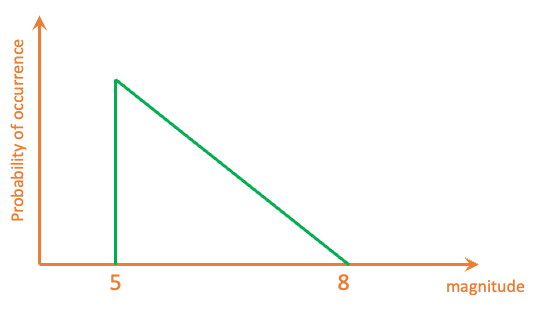

(array([1852., 1766., 1476., 1298., 1094.,  845.,  725.,  520.,  307.,
         117.]),
 array([5.00002825, 5.29584607, 5.59166388, 5.8874817 , 6.18329952,
        6.47911733, 6.77493515, 7.07075297, 7.36657079, 7.6623886 ,
        7.95820642]),
 <a list of 10 Patch objects>)

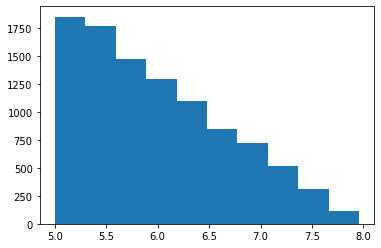

In [ ]:
def getEarthquakeMagnitude():

    # Define a triangular distribution between 5 and 8
    return rng.triangular(5,5,8)

# Let's check if our implementation was succesfull by generating 10,000 realizations of the magnitude distribution
plt.hist([getEarthquakeMagnitude() for i in range(10000)]) 
# I am calling the function getEarthquakeMagnitude() in a for loop that goes from 0-9999, that is 10,000 calls of the function
# I store that as a list, hence the [ ]
# I am using a quick plotting approach, plt.hist()

# <font color='orange'> Ground shaking intensity </font> 

The Magnitude is a metric of energy released. This is different from ground shaking intensity because the ground shaking intensity is dependent on *where you are*. If you are on top of the fault line you will experience a lot of shaking. However, if you are multiple kilometres away, the energy in the earthquake waves dissipates as they travel. [We say that the waves attenuate as they travel further](https://www.usgs.gov/media/videos/attenuation#:~:text=The%20waves%20are%20largest%20where,away%20from%20the%20earthquake%20source.). 

Ground shaking intensity depends on three factors:

1) If you are 10 kilometres away from the epicentre, the larger the earthquake, the more shaking you will experience;

2) For an earthquake of magnitude 6.5, the further you are from the epicentre the least amount of shaking you will experience;

3) The softer the soil under you the more shaking you will experience.

Multiple scholars have developed models to estimate how much earthquake waves attenuate as they travel. They create *Ground Motion Prediction Equations* (GMPEs) to help us estimate that. These GMPEs are often a function of the Magnitude (M), distance to epicentre (R), and soil properties. 

In the following, I give you one example of a GMPE - the Boore, Joyner, Fumal (1997). Note, this GMPE is *obsolete* nowadays. It has been superseded by more sophisticated models that are difficult to implement. However, this GMPE is a good introduction to the topic.

In [ ]:
# As long as you understood the concept of attenuation, do not worry too much about this model/GMPE.
def getShakingIntensity(M, R, Vs30): # M: magnitude, R: distance to epicentre, Vs30 is a soil parameter

    # Coefficients of the Boore, Joyner, Fumal (1997) ground motion model for period of 1s.
    # The 'a' coefficients are extracted from linear regression.
    a1 = -3.4415 
    a2 = 1.42
    a3 = -0.032
    a4 = -0.798
    a5 = 8.41
    a6 = -0.698

    # Mean spectral acceleration at the 1s period
    ln_a = a1 + a2*M + a3*M**2 + a4*np.log(np.sqrt(R**2 + a5)) + a6*np.log(Vs30)  # np.log is the natural logarithm function; np.sqrt is the squared root

    return np.exp(ln_a)

# <font color='orange'> Simulation </font> 

The cell below simulates a single scenario defined by a (i) random magntitude, and (ii) random epicentre location.

In [ ]:
nblds = len(df_Alameda.index)


theMagnitude = getEarthquakeMagnitude() # this a function we defined above
theEpicentreLatitude,theEpicentreLongitude = simulateEpicentreLocation()  # this a function we defined above

theDistanceToEpicentreList = []
theShakingIntensityList = []

# For each building in the community (i.e., the number of rows in df_Alameda)
for b in range(nblds):

    # Calculate distance between this building and the epicentre
    coords_1 = (df_Alameda.loc[b,'Latitude'], df_Alameda.loc[b,'Longitude'])
    coords_2 = (theEpicentreLatitude, theEpicentreLongitude)

    # This function calculates the distance between two points on the surface of a geoid (https://www.movable-type.co.uk/scripts/latlong.html)
    # Specifically, the distance between the EQ and buildig 'b'
    theDistanceToEpicentre = geopy.distance.geodesic(coords_1, coords_2).km

    # Calculate shaking intensity at the location of building b
    myShakingIntensity = getShakingIntensity(M=theMagnitude, R=theDistanceToEpicentre, Vs30=300) # this a function we defined above

    theDistanceToEpicentreList.append(theDistanceToEpicentre)
    theShakingIntensityList.append(myShakingIntensity)


df_Alameda['DistanceToEpicentre'] = theDistanceToEpicentreList
df_Alameda['ShakingIntensity'] = theShakingIntensityList

df_Alameda[['Longitude','Latitude','DistanceToEpicentre','ShakingIntensity']].head(3)

,Longitude,Latitude,DistanceToEpicentre,ShakingIntensity
0,-122.237670,37.756951,20.370971,0.031980
1,-122.239088,37.734668,22.594470,0.029487
2,-122.233459,37.734820,22.767928,0.029310


Plot the results of the one realization

In [ ]:
# And plot a map with the data underneath
df_plt = df_Alameda.copy()
df_plt['ShakingIntensity'] = df_plt['ShakingIntensity'].multiply(10)
df_plt['ShakingIntensity']
gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'ShakingIntensity',
                        color_continuous_scale='Viridis',
                        zoom=12.2,
                        height=700,
                        width=800
                      )
fig.show()

# <font color='orange'> Homework Tasks </font> 

<font color='cyan'>Task 1</font> - Create a workflow to represent the model above highlighting the models in the workflow, what data are used in each model, and what elements are uncertain and how the uncertainty is accounted for.

<font color='cyan'>Task 2</font>  - Represent the simulation (i.e., Simulation cell) using a flowchart. The flowchart should allow the reader to understand what is involved in each step of the simulation. However, details might be omitted.

<font color='cyan'>Task 3</font> - Starting from the Simulation cell. Create a set of three scenarios with varying magnitudes:

S0 -> M:6.9

S1 -> M:7.0

S2 -> M:7.1

For each scenario, run 50 realizations of the epicentre location. That is, you will run a total of 150 (3x50) simulations. For each scenario, for each building, calculate the <font color='orange'>mean</font> ground shaking intensity in *g*. Plot one map of ground shaking intensity per scenario.  

*Suggested approach*:

For each scenario (e.g., M=7.0) you will get a dataframe with one value per REALIZATION:

df_realizations:

| Building | R1 | R2 | ... | R50 | 
| ---       | ---   | ---   | ---   | --- |
|1 | 0.5 | 0.3 | ... | 0.67 |
|2 | 0.6 | 0.3 | ... | 0.7 |
|3 | 0.7 | 0.25 | ... | 0.8 |
| ... | ... | ... | ... | ... |
|nblds  | 0.5 | 0.3 | ... | 0.67 |

For each SCENARIO, you want the mean of the 50 REALIZATIONS. If the dataframe above is named df_realizations, you can get the mean of each column as df_realizations.mean(axis=1). Thus, you can simply store one value per building per SCENARIO, that is

df_Means:

| Building | S1 | S2 | ... | S6 | 
| ---       | ---   | ---   | ---   | --- |
|1 | 0.5 | 0.3 | ... | 0.67 |
|2 | 0.6 | 0.3 | ... | 0.7 |
|3 | 0.7 | 0.25 | ... | 0.8 |
| ... | ... | ... | ... | ... |
|nblds  | 0.5 | 0.3 | ... | 0.67 |


Note: your workflow should run the 3 scenarios with a single click. Do not create a workflow that requires multiple independent runs.

Tip: During development, build your workflow to run 2 realizations of 2 scenarios. That will be much faster to run and to identify problems. Once you are confident about your workflow, expand to 50 realizations and 3 scenarios.

Tip: Once you have your dataframe df_Means, add to it the latitute and longitude of each building. That makes plotting the maps easy.

<font color='orange'>Warning</font>: 50 realizations is a small amount to get consistent statistics. In practical applications we use thousands or even hundreds of thousands. Thus, you may obtain different results from is shown below, or even if you run your set of simulations multiple times.

In [ ]:
df_Means = pd.DataFrame()

###
# HERE GOES YOUR CODE
###

df_Means['Latitude'] = df_Alameda['Latitude']
df_Means['Longitude'] = df_Alameda['Longitude']

Starting scenario 0
Starting scenario 1
Starting scenario 2


In [ ]:
# Your dataframe should look like this at the end
df_Means

,S0,S1,S2,Latitude,Longitude
0,0.336296,0.401366,0.414600,37.756951,-122.237670
1,0.315056,0.369531,0.384678,37.734668,-122.239088
2,0.322015,0.378101,0.392545,37.734820,-122.233459
3,0.328864,0.391422,0.408455,37.758740,-122.244661
4,0.313789,0.368148,0.398449,37.769787,-122.266297
...,...,...,...,...,...
15423,0.313222,0.359287,0.400624,37.785907,-122.282454
15424,0.302340,0.353723,0.371363,37.738752,-122.253801
15425,0.301400,0.352489,0.370280,37.738681,-122.254643
15426,0.345130,0.415363,0.427200,37.763473,-122.234257


In [ ]:
# Use this code to plot the maps
df_plt = df_Means.copy() # df_Means contain the mean for each building for each scenario.

gdf_plt = gpd.GeoDataFrame(df_plt, geometry=gpd.points_from_xy(df_plt.Longitude, df_plt.Latitude), crs='epsg:4326')

fig1 = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'S0', # Results from Scenario 0
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )

fig2 = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'S1',
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )

fig3 = px.scatter_mapbox(gdf_plt, 
                        lat = gdf_plt['Latitude'],
                        lon = gdf_plt['Longitude'],
                        center={"lat": 37.760, "lon": -122.264},
                        mapbox_style="carto-positron",
                        color = 'S2',
                        color_continuous_scale='Viridis',
                        zoom=12,
                        height=700,
                        width=800
                      )


fig1.show(), fig2.show(), fig3.show()

(None, None)

<font color='cyan'>Task 4</font> - Using the results from (3), calculate the probability that a building, selected at random, would experience at leas 0.4g of ground acceleration (note: ground acceleration is what you calculated in (3)).

/usr/local/lib/python3.8/dist-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning:

'stat_bin()' using 'bins = 40'. Pick better value with 'binwidth'.



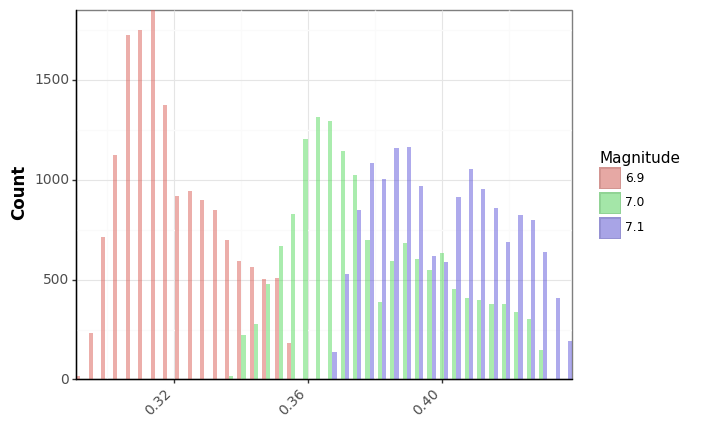

<ggplot: (8745729185491)>

In [ ]:
# This code should produce a histogram of your data if it was correctly organized
df_plot = df_Means.drop(['Latitude','Longitude'],axis=1).rename(columns={"S0":'6.9',
                                                                         "S1":'7.0',
                                                                         'S2':'7.1',
                                                                         })

df_plot_long = pd.melt(df_plot)

plot_base = ggplot(df_plot_long,aes(x='value',fill='variable',group='variable')) + geom_histogram(alpha=0.5,position='dodge')

plot_clean = plot_base + theme_bw() + theme(
  axis_line=element_line(size=1),
  axis_text=element_text(size=10),
  axis_title=element_text(size=12,face="bold"),
  axis_text_x = element_text(angle = 45, hjust=1),
) +\
labs(fill='Magnitude') +\
scale_x_continuous(name = '',expand=[0,0]) +\
scale_y_continuous(name = 'Count',expand=[0,0])
plot_clean

In [ ]:
###
# The code I used was in this cell (note, you will likely not get the same values, use the histogram above to 'sanity check' your results.)
###

The probability that a building will experience shaking larger than 0.5g in scenario S0 is 1.0
The probability that a building will experience shaking larger than 0.5g in scenario S1 is 0.7966683951257454
The probability that a building will experience shaking larger than 0.5g in scenario S2 is 0.50427793621986
